In [1]:
import geopandas as gpd
import pandas as pd
import datetime
from dateutil import tz
import stride
import folium

In [2]:
pd.options.display.max_columns = 1000
pd.options.display.max_colwidth = 1000

In [3]:
def localize_dates(data, dt_columns = []):
    data = data.copy()
    
    for c in dt_columns:
        data[c] = pd.to_datetime(data[c]).dt.tz_convert('Israel')
    
    return data

In [4]:
pd.DataFrame(stride.get('/gtfs_routes/list', {'route_short_name':490,
                                                            'agency_name': 'אגד',
                                                            'route_long_name_contains': 'ירושלים',
                                              'date_from': '2022-12-12',
                                              'date_to':  '2022-12-12'}))

,id,date,line_ref,operator_ref,route_short_name,route_long_name,route_mkt,route_direction,route_alternative,agency_name,route_type
0,1868868,2022-12-12,34316,3,490,ת.רכבת תל אביב - סבידור/רציפים B-תל אביב יפו<->ברעם/האומן-ירושלים-1#,13490,1,#,אגד,3
1,1868869,2022-12-12,34317,3,490,ברעם/האומן-ירושלים<->ת. רכבת תל אביב - סבידור/הורדה-תל אביב יפו-3#,13490,3,#,אגד,3


In [5]:
siri_locations_490_before = pd.DataFrame(stride.get('/siri_vehicle_locations/list', {
    'siri_routes__line_ref': '34317',
    'limit': -1,
    'siri_rides__schedualed_start_time_from': datetime.datetime(2022,12, 4, tzinfo=tz.gettz('Israel')),
    'siri_rides__schedualed_start_time_to': datetime.datetime(2022,12, 8, tzinfo=tz.gettz('Israel'))+datetime.timedelta(days=1),
    'order_by': 'recorded_at_time desc',
    'lon__greater_or_equal': 35.11072,
    'lon__lower_or_equal': 35.19670,
    'lat__greater_or_equal': 31.76620,
    'lat__lower_or_equal': 31.81334
}))

siri_locations_490_before.shape

(1721, 35)

In [6]:
dt_columns = ['recorded_at_time','siri_ride__scheduled_start_time']

siri_locations_490_before = localize_dates(siri_locations_490_before, dt_columns)

In [7]:
siri_locations_490_before.columns

Index(['id', 'siri_snapshot_id', 'siri_ride_stop_id', 'recorded_at_time',
       'lon', 'lat', 'bearing', 'velocity', 'distance_from_journey_start',
       'distance_from_siri_ride_stop_meters', 'siri_snapshot__id',
       'siri_snapshot__snapshot_id', 'siri_snapshot__etl_status',
       'siri_snapshot__etl_start_time', 'siri_snapshot__etl_end_time',
       'siri_snapshot__error',
       'siri_snapshot__num_successful_parse_vehicle_locations',
       'siri_snapshot__num_failed_parse_vehicle_locations',
       'siri_snapshot__num_added_siri_rides',
       'siri_snapshot__num_added_siri_ride_stops',
       'siri_snapshot__num_added_siri_routes',
       'siri_snapshot__num_added_siri_stops', 'siri_snapshot__last_heartbeat',
       'siri_snapshot__created_by', 'siri_ride__id', 'siri_ride__journey_ref',
       'siri_ride__scheduled_start_time', 'siri_ride__vehicle_ref',
       'siri_ride__first_vehicle_location_id',
       'siri_ride__last_vehicle_location_id', 'siri_ride__duration_minutes'

In [8]:
locations_490_before = siri_locations_490_before[['recorded_at_time','siri_ride__scheduled_start_time',
                                   'lon','lat','siri_ride__vehicle_ref', 'siri_ride__id', 'distance_from_journey_start', 'velocity']]

In [9]:
ride_gpd = gpd.GeoDataFrame(locations_490_before, geometry=gpd.points_from_xy(locations_490_before.lon, locations_490_before.lat))

C:\Users\asher\Miniconda3\envs\siri\lib\site-packages\geopandas\array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


## Visualizing the data to see if nothing looks wrong

In [10]:
m = folium.Map(location=[31.78,35.18], zoom_start=12, tiles='OpenStreetMap')
glist = [[point.xy[1][0], point.xy[0][0]] for point in ride_gpd.geometry]
for i, coo in enumerate(glist):
    m.add_child(
        folium.Marker(
            location=coo,
            popup=ride_gpd.recorded_at_time[i],
            icon = folium.Icon()
        )
    )
m

#### Now let's look at the last siri call of each ride

In [11]:
last_recs = ride_gpd.groupby('siri_ride__id').first()

m = folium.Map(location=[31.78,35.14], zoom_start=13, tiles='OpenStreetMap')
glist = [[point.xy[1][0], point.xy[0][0]] for point in last_recs.geometry]
for i, coo in zip(last_recs.index, glist):
    m.add_child(
        folium.Marker(
            location=coo,
            popup=i
        )
    )

m

##### All the data points are after "Hemed" bus stop, except for ride #25405175

#### The same for the first siri call:

In [12]:
first_recs = ride_gpd.groupby('siri_ride__id').last()

m = folium.Map(location=[31.77,35.19], zoom_start=15, tiles='OpenStreetMap')
glist = [[point.xy[1][0], point.xy[0][0]] for point in first_recs.geometry]
for i, coo in zip(first_recs.index, glist):
    m.add_child(
        folium.Marker(
            location=coo,
            popup=i
        )
    )

m

#### Now let's create a single DF with the first and last calls for each ride

In [13]:
first_last = first_recs.join(last_recs, rsuffix='_last')
first_last.columns

Index(['recorded_at_time', 'siri_ride__scheduled_start_time', 'lon', 'lat',
       'siri_ride__vehicle_ref', 'distance_from_journey_start', 'velocity',
       'geometry', 'recorded_at_time_last',
       'siri_ride__scheduled_start_time_last', 'lon_last', 'lat_last',
       'siri_ride__vehicle_ref_last', 'distance_from_journey_start_last',
       'velocity_last', 'geometry_last'],
      dtype='object')

##### Removing the problematic ride:

In [14]:
first_last = first_last.drop(25405175)

##### Creating measures:

In [15]:
first_last['distance_traveled'] = first_last['distance_from_journey_start_last'] - first_last['distance_from_journey_start']
first_last['distance_traveled'].describe()

count      153.000000
mean      9098.810458
std        421.099497
min       8128.000000
25%       8788.000000
50%       9089.000000
75%       9448.000000
max      10157.000000
Name: distance_traveled, dtype: float64

In [16]:
first_last['time_traveled'] = first_last['recorded_at_time_last'] - first_last['recorded_at_time']
first_last['time_traveled'].describe()

count                          153
mean     0 days 00:10:17.934640522
std      0 days 00:02:14.875072469
min                0 days 00:06:59
25%                0 days 00:08:56
50%                0 days 00:09:35
75%                0 days 00:11:04
max                0 days 00:19:35
Name: time_traveled, dtype: object

In [17]:
first_last['mins_traveled'] = first_last['time_traveled'].dt.total_seconds()/60
first_last['ride_start_time'] = first_last['siri_ride__scheduled_start_time'].dt.hour + first_last['siri_ride__scheduled_start_time'].dt.minute/60

<AxesSubplot: xlabel='ride_start_time', ylabel='mins_traveled'>

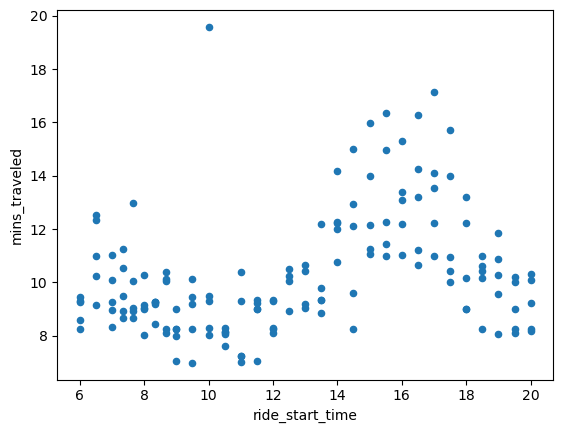

In [18]:
first_last.plot.scatter('ride_start_time', 'mins_traveled')

#### It seems that there's one outlier, but let's keep it for now

### Now' let's compute the average travel time based on the departure time of the bus

C:\Users\asher\AppData\Local\Temp\ipykernel_50808\1485209791.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avgs = first_last.groupby('ride_start_time').mean().reset_index()


<AxesSubplot: xlabel='ride_start_time'>

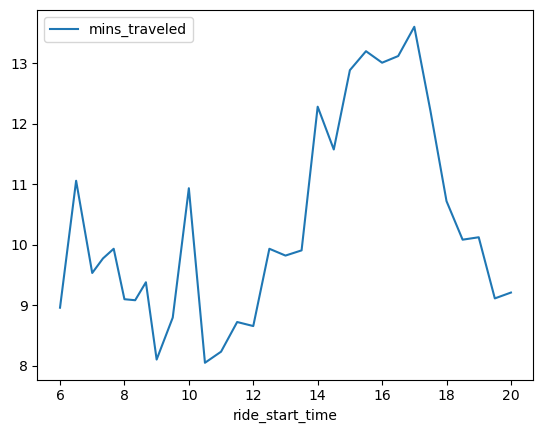

In [19]:
avgs = first_last.groupby('ride_start_time').mean().reset_index()
avgs.plot.line('ride_start_time', 'mins_traveled')

In [20]:
#avgs.to_excel('before_ramp.xlsx')